## Code for figures

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, Normalizer, FunctionTransformer, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import SGDRegressor, Ridge
from sklearn.model_selection import train_test_split, cross_val_score


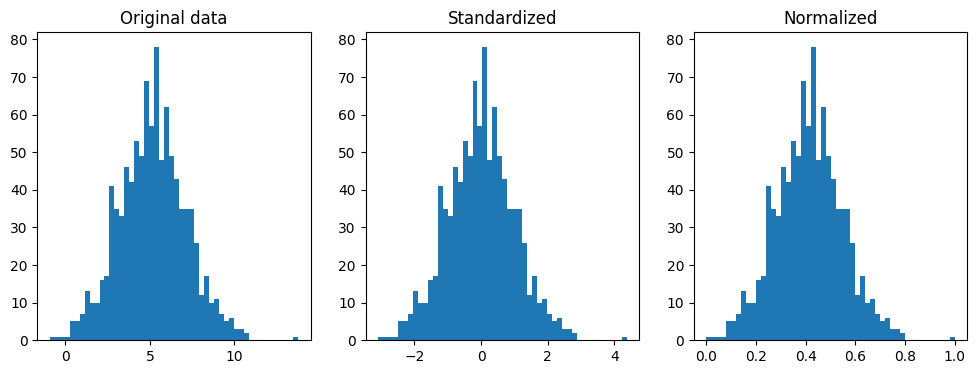

In [60]:
rng = np.random.default_rng(seed=123456)
x = rng.normal(5, 2, 1000)

fig, axes = plt.subplots(1, 3, figsize=(12,4))
axes[0].hist(x, bins=50)
axes[0].set_title("Original data")
axes[1].hist((x - x.mean()) / x.std(), bins=50)
axes[1].set_title("Standardized")
axes[2].hist((x - x.min())/(x.max() - x.min()), bins=50)
axes[2].set_title("Normalized")

plt.savefig("../../static/img/05-scaling.png")

## Fake data to demonstrate scaling and nonlinear transforms

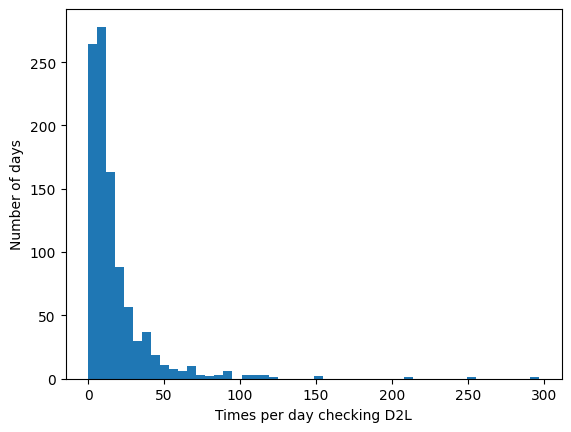

In [61]:
# generate some fake count data
# From Intro to Machine Learning with Python
X_org = rng.normal(size=(1000, 3))
X = rng.poisson(10 * np.exp(X_org))

plt.hist(X[:,1], bins=50)

plt.xlabel("Times per day checking D2L")
plt.ylabel("Number of days")

plt.savefig("../../static/img/05-counts.png")

## Side comment on the central limit theorem
Sums of independent and identically distributed random variables converge to normal as number of samples increases.

As soon as one of those criteria are missing, you can't count on it anymore!

Text(0, 0.5, 'Number of days')

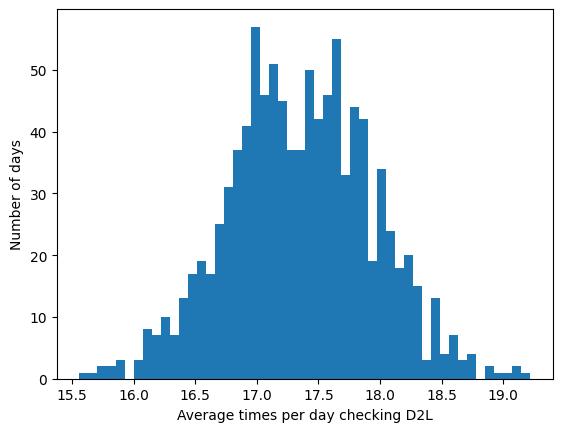

In [62]:
# CLT version
X_c = np.zeros(1000)
for i in range(len(X)):
    X_c[i] = rng.poisson(X[:,1].mean(), size=50).mean()

plt.hist(X_c, bins=50)

plt.xlabel("Average times per day checking D2L")
plt.ylabel("Number of days")

## Back to the fake data
Create a fake (scalar) output using the "counts" data X (which is actually a matrix of 3 features) as input.

Note that the data generation doesn't actually use the count data directly, but instead is a linearly weighted combination of the normally distributed random samples that were used as parameters in the poisson distribution.

In [72]:
# Generate some more fake features and a fake X
# Repeated runs of the same cell results in different values unless we re-seed
rng = np.random.default_rng(seed=42)
w = rng.normal(size=3)
y = X_org.dot(w)

# the usual split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

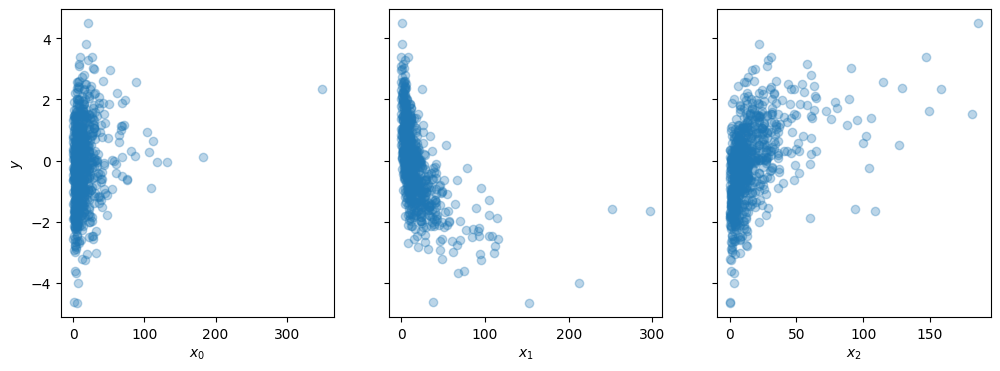

In [81]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
axes[0].set_ylabel("$y$")
for i in range(3):
    axes[i].scatter(X_train[:,i], y_train, alpha=0.3)
    axes[i].set_xlabel(f"$x_{i}$")

In [85]:
# train a regression model on the raw data using stochastic gradient descent
model = SGDRegressor()
cross_val_score(model, X_train, y_train)

array([-2.01068744e+21, -3.93302613e+22, -1.95340867e+24, -1.77108247e+22,
       -3.05183612e+21])

In [ ]:
# Add on the preprocessing pipeline
pipeline = make_pipeline(
    # FunctionTransformer(np.log1p), # log + 1 
    StandardScaler(),
    model
)

cross_val_score(pipeline, X_train, y_train)

array([0.83693023, 0.85848663, 0.91515386, 0.85650368, 0.8775251 ])

Text(2, -3, 'MSE = 0.22')

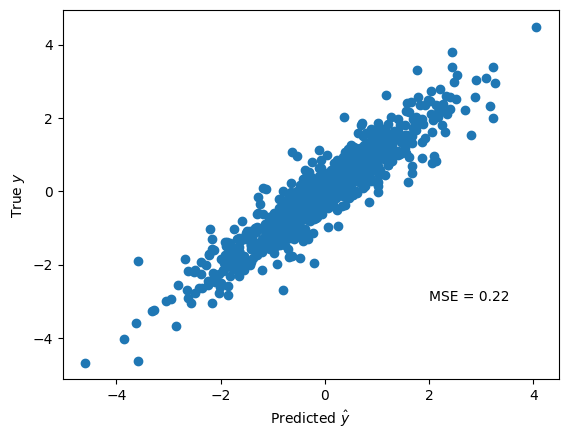

In [ ]:
pipeline.fit(X_train, y_train)
y_est = pipeline.predict(X_train)
plt.scatter(y_est, y_train)
plt.xlabel(r"Predicted $\hat{y}$")
plt.ylabel("True $y$")
plt.text(2, -3, f"MSE = {np.mean((y_train - y_est)**2):.2f}")

## Mixed data types: Categorical and numeric


In [2]:
# Revisit the OKCupid data
df = pd.read_csv("../04_categorical/profiles_revised.csv")

In [15]:
# Target: job is "other" or "rather not say"
df["job"].value_counts()
df["mystery_job"] = df["job"].apply(lambda j: j in ["other", "rather not say"])

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59946 entries, 0 to 59945
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          59946 non-null  int64  
 1   body_type    54650 non-null  object 
 2   diet         35551 non-null  object 
 3   drinks       56961 non-null  object 
 4   drugs        45866 non-null  object 
 5   education    53318 non-null  object 
 6   ethnicity    54266 non-null  object 
 7   height       59943 non-null  float64
 8   income       59946 non-null  int64  
 9   job          51748 non-null  object 
 10  offspring    24385 non-null  object 
 11  orientation  59946 non-null  object 
 12  pets         40025 non-null  object 
 13  religion     39720 non-null  object 
 14  sex          59946 non-null  object 
 15  sign         48890 non-null  object 
 16  smokes       54434 non-null  object 
 17  speaks       59896 non-null  object 
 18  status       59946 non-null  object 
 19  myst

In [ ]:
# select features to use in the model
numeric_features = ["age", "height", "income"]
cat_features = ["drinks", "education", "sex"]

X = df[numeric_features + cat_features]
y = df["mystery_job"].astype(int)

# split!
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=12345)